<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import pandas as pd
import numpy as np
import re

In [48]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_nonascii(sent):
  return "".join([i for i in sent if i.isascii()])

In [96]:
dff=pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv")

In [100]:
dff.split.value_counts()

train    10240
valid     1284
test      1267
Name: split, dtype: int64

In [99]:
df=pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv")
# df=pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/CodaLab Covid/Constraint_English_All.csv")
df["text"]=df["statement"]
# df["text"]=df["tweet"]

df=df[["ID","label","text","split"]]
# df=df[["id","label","text"]]

df = df.dropna(subset=['text'], how='all')
df.info()
df = df.reset_index(drop=True)
df['text'] = df['text'].replace(np.nan, '', regex=True)
df = df.dropna(subset=['text'], how='all')
df= df.drop_duplicates(subset=["text"])
df.duplicated(subset='text', keep='first').sum()

df['text']=df["text"].apply(remove_urls)
df['text']=df["text"].apply(remove_nonascii)

sentences = df["text"].tolist()
labels = df["label"].tolist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12791 entries, 0 to 12790
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      12791 non-null  object
 1   label   12791 non-null  object
 2   text    12791 non-null  object
 3   split   12791 non-null  object
dtypes: object(4)
memory usage: 499.6+ KB


# Text Classification - Deep Learning CNN Models


<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/cnn.png?raw=1">

In [50]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D ,TimeDistributed
from tensorflow.keras.layers import Embedding ,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

### Prepare Train Test Split

In [54]:
df["label"].value_counts()

0    7123
1    5642
Name: label, dtype: int64

In [53]:
df["label"]=df["label"].replace(["true","mostly-true","half-true"],0)
df["label"]=df["label"].replace(["false","barely-true","pants-fire"],1)

# df["label"]=df["label"].replace(["real"],0)
# df["label"]=df["label"].replace(["fake"],1)

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
# build train and test datasets
reviews = df['text'].values
sentiments = df['label'].values
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews, sentiments, test_size=0.3, random_state=142,stratify=sentiments)

# train_reviews = reviews[:35000]
# train_sentiments = sentiments[:35000]

# test_reviews = reviews[35000:]
# test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [57]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [58]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 3830/3830 [00:00<00:00, 5090.64it/s]

CPU times: user 2.4 s, sys: 295 ms, total: 2.7 s
Wall time: 2.49 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [59]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [60]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('appease', 12558), ('<PAD>', 0), 1)

In [61]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [62]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [63]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=12559
Number of Documents=8935


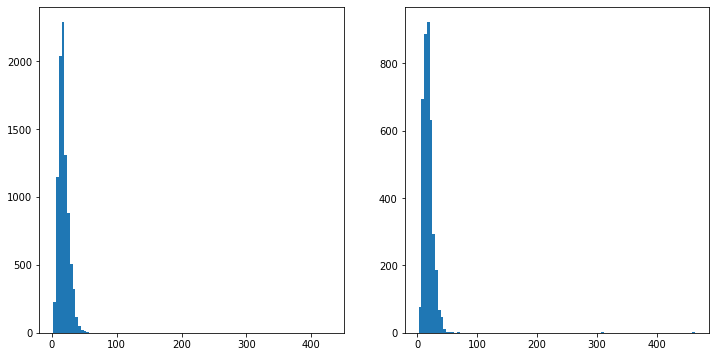

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens,bins = 100)
h2 = ax[1].hist(test_lens,bins = 100)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [65]:
MAX_SEQUENCE_LENGTH = 50

In [66]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((8935, 50), (3830, 50))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [67]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [68]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [69]:
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

12559

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [93]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=16

In [94]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
# model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 300)           3767700   
                                                                 
 conv1d_62 (Conv1D)          (None, 50, 128)           153728    
                                                                 
 max_pooling1d_62 (MaxPoolin  (None, 25, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_63 (Conv1D)          (None, 25, 64)            32832     
                                                                 
 max_pooling1d_63 (MaxPoolin  (None, 12, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_64 (Conv1D)          (None, 12, 32)          

## Model Training

In [95]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/10
503/503 [==============================] - 11s 17ms/step - loss: 0.6739 - accuracy: 0.5804 - val_loss: 0.6756 - val_accuracy: 0.5940
Epoch 2/10
503/503 [==============================] - 7s 14ms/step - loss: 0.5589 - accuracy: 0.7244 - val_loss: 0.6877 - val_accuracy: 0.5917
Epoch 3/10
503/503 [==============================] - 7s 14ms/step - loss: 0.3440 - accuracy: 0.8535 - val_loss: 0.8512 - val_accuracy: 0.5817
Epoch 4/10
503/503 [==============================] - 7s 14ms/step - loss: 0.1529 - accuracy: 0.9401 - val_loss: 1.1497 - val_accuracy: 0.5884
Epoch 5/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0643 - accuracy: 0.9790 - val_loss: 1.4322 - val_accuracy: 0.5727
Epoch 6/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0353 - accuracy: 0.9882 - val_loss: 1.7509 - val_accuracy: 0.5828
Epoch 7/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 2.0246 - val_accuracy: 0.573

## Model Evaluation

In [98]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

120/120 [==============================] - 1s 6ms/step - loss: 2.1361 - accuracy: 0.5752
Accuracy: 57.52%


In [84]:
predictions = model.predict(X_test).ravel()
predictions[:10]

array([2.1054146e-03, 6.0295534e-01, 1.0497563e-04, 1.7012902e-01,
       9.5259506e-01, 8.4208772e-02, 3.0068890e-03, 1.6741516e-02,
       4.0793486e-02, 9.4101864e-01], dtype=float32)

In [85]:
predictions = [1 if item >0.5 else 0 for item in predictions]
predictions[:10]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 1]

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

labels = [0 , 1]
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      2137
           1       0.52      0.48      0.50      1693

    accuracy                           0.58      3830
   macro avg       0.57      0.57      0.57      3830
weighted avg       0.57      0.58      0.57      3830



,0,1
0,1400,737
1,887,806
